In [1]:
import os
import shutil
import pandas as pd

# Ganti path ini ke lokasi dataset kamu di komputer
base_dir = r'D:\Kuliah\Semester 5\Kecerdasan Buatan\pratikum\Posttest3\PA\dataset\Tomato Detection Fresh or Rotten'

# Cek apakah foldernya benar
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Folder dataset tidak ditemukan di {base_dir}")

print("Isi folder dataset:", os.listdir(base_dir))


Isi folder dataset: ['test', 'train', 'valid']


In [2]:
# Memisah Pisahkan Gambar Berdasarkan Label di _annotations.csv

# Loop untuk setiap subset (train, valid, test)
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(base_dir, split)
    csv_path = os.path.join(split_dir, '_annotations.csv')

    # Pastikan file CSV ada
    if not os.path.exists(csv_path):
        print(f'⚠️ CSV tidak ditemukan di {split_dir}')
        continue

    df = pd.read_csv(csv_path)

    # Deteksi kolom nama file dan label
    if 'file_name' in df.columns:
        img_col = 'file_name'
    elif 'filename' in df.columns:
        img_col = 'filename'
    else:
        raise ValueError("Kolom nama file tidak ditemukan di CSV.")

    label_col = 'class' if 'class' in df.columns else 'label'

    # Pisahkan gambar sesuai label
    for _, row in df.iterrows():
        img_name = row[img_col]
        label = row[label_col]

        src = os.path.join(split_dir, img_name)
        dst_dir = os.path.join(split_dir, label)
        os.makedirs(dst_dir, exist_ok=True)

        dst = os.path.join(dst_dir, img_name)
        if os.path.exists(src):
            shutil.move(src, dst)

    print(f'✅ Berhasil mengelompokkan data {split}')

✅ Berhasil mengelompokkan data train
✅ Berhasil mengelompokkan data valid
✅ Berhasil mengelompokkan data test


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = f'{base_dir}/train'
val_dir   = f'{base_dir}/valid'
test_dir  = f'{base_dir}/test'

# Generator untuk training dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator tanpa augmentasi untuk validasi dan test
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6684 images belonging to 2 classes.
Found 637 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


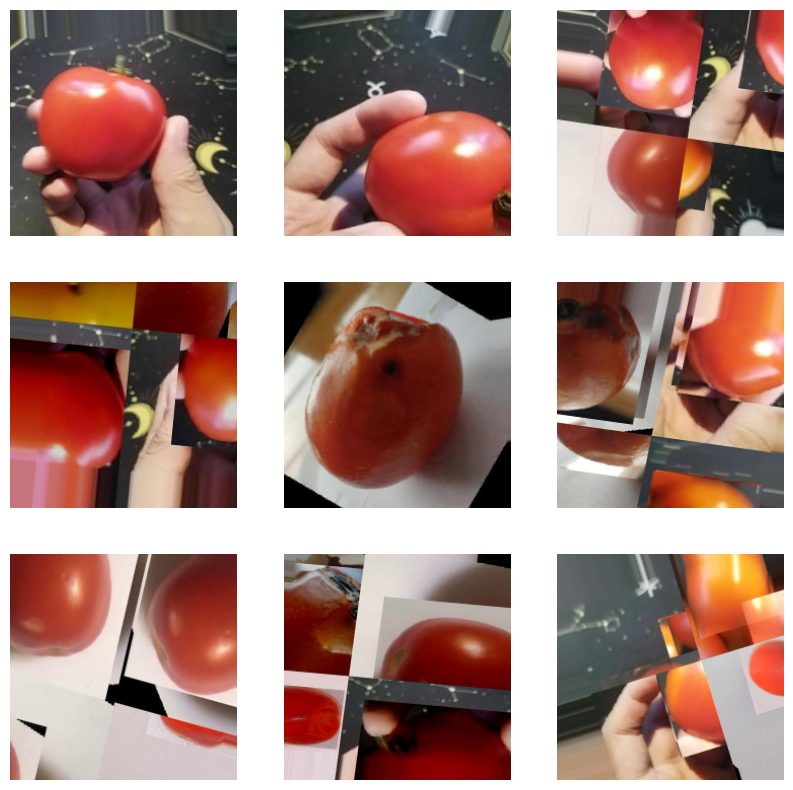

In [4]:
# Visualisasi
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, GlobalAveragePooling2D, Dense,
    Dropout, BatchNormalization, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Base model MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze layer pretrained

# === Bangun model Sequential ===
model = Sequential([
    base_model,

    # Blok tambahan (khusus adaptasi ke pola tomat)
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Kelas: Segar & Busuk
])

# Compile model 
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 64)            │         737,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,004,162 (11.46 MB)

 Trainable params: 746,050 (2.85 MB)

 Non-trainable params: 2,258,112 (8.61 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_tomato_model.keras',   # format baru Keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Gabungkan kedua callback
callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)


C:\Users\vashi\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.6890 - loss: 0.6497
Epoch 1: val_accuracy improved from None to 0.95761, saving model to best_tomato_model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 213s 995ms/step - accuracy: 0.7323 - loss: 0.5974 - val_accuracy: 0.9576 - val_loss: 0.2357
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.7831 - loss: 0.5295
Epoch 2: val_accuracy improved from 0.95761 to 0.96546, saving model to best_tomato_model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 248s 929ms/step - accuracy: 0.7816 - loss: 0.5285 - val_accuracy: 0.9655 - val_loss: 0.1942
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7940 - loss: 0.4987
Epoch 3: val_accuracy improved from 0.96546 to 0.97959, saving model to best_tomato_model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 199s 916ms/step - accuracy: 0.7938 - loss: 0.4949 - val_accuracy: 0.9796 - val_loss: 0.1735
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.7937 - loss: 0.4841


In [7]:
# === Tahap Fine-Tuning ===
base_model.trainable = True

# Bekukan sebagian besar layer awal (biar tidak reset total)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile ulang dengan learning rate lebih kecil
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Latih lagi beberapa epoch
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7611 - loss: 0.5433
Epoch 1: val_accuracy did not improve from 0.98901
209/209 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.7846 - loss: 0.5025 - val_accuracy: 0.9294 - val_loss: 0.2444
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8068 - loss: 0.4569
Epoch 2: val_accuracy did not improve from 0.98901
209/209 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.8066 - loss: 0.4534 - val_accuracy: 0.9529 - val_loss: 0.1652
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8323 - loss: 0.4101
Epoch 3: val_accuracy did not improve from 0.98901
209/209 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.8205 - loss: 0.4225 - val_accuracy: 0.9576 - val_loss: 0.1705
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8331 - loss: 0.4058
Epoch 4: val_accuracy did not improve from 0.98901
209/209 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8259 - loss: 0.4121 - val_accuracy: 0.9717 - v

In [8]:
# Evaluasi Model
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n🔹 Akurasi Data Test     : {test_acc*100:.2f}%")
print(f"🔹 Loss Data Test        : {test_loss:.4f}")

# Akurasi Training & Validation dari history
train_acc = history.history['accuracy'][-1] * 100
val_acc   = history.history['val_accuracy'][-1] * 100
train_loss = history.history['loss'][-1]
val_loss   = history.history['val_loss'][-1]

print(f"🔹 Akurasi Data Train    : {train_acc:.2f}%")
print(f"🔸 Akurasi Data Validasi : {val_acc:.2f}%")
print(f"🔹 Loss Data Train       : {train_loss:.4f}")
print(f"🔸 Loss Data Validasi    : {val_loss:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 578ms/step - accuracy: 0.9375 - loss: 0.2418

🔹 Akurasi Data Test     : 93.75%
🔹 Loss Data Test        : 0.2418
🔹 Akurasi Data Train    : 85.71%
🔸 Akurasi Data Validasi : 98.12%
🔹 Loss Data Train       : 0.3564
🔸 Loss Data Validasi    : 0.0925


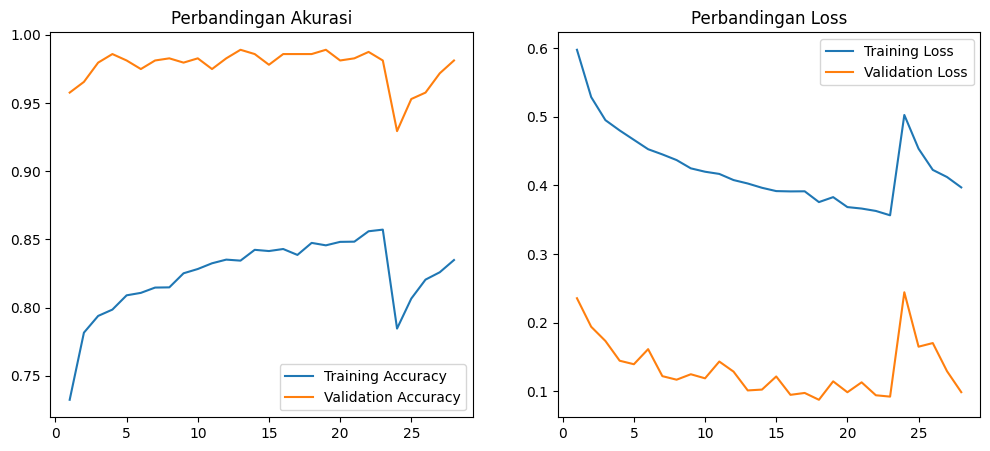

In [9]:
import matplotlib.pyplot as plt

# Gabung nilai accuracy dan loss dari kedua tahap
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot hasil
plt.figure(figsize=(12,5))

# Akurasi
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Perbandingan Akurasi')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Perbandingan Loss')
plt.legend()

plt.show()


In [5]:
from tensorflow.keras.models import load_model
model = load_model("mnist_cnn.h5")
print(model.input_shape)


(None, 224, 224, 3)


In [7]:
import tensorflow as tf
model.save("mnist_cnn.h5")
print("Model berhasil disimpan sebagai mnist_cnn.h5")
model = tf.keras.models.load_model('mnist_cnn.h5')

Model berhasil disimpan sebagai mnist_cnn.h5
